# History Summary

### 1. Import and Load

In [139]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_axes_aligner import shift

#### 1.1 Get History File Paths

In [2]:
output_dir = './summary/v1.5/'
history_dir = './history/'
versions_in_scope = ['v1.2','v1.4','v1.5']

os.makedirs(output_dir,exist_ok=True)
os.makedirs(history_dir,exist_ok=True)

versions, datasets, fx_models, clf_models, runs, paths = [], [], [], [], [], []

for version in os.listdir(history_dir):
    if version not in versions_in_scope:
        continue
    version_dir = os.path.join(history_dir,version)
    for dataset in os.listdir(version_dir):
        dataset_dir = os.path.join(version_dir,dataset)
        for model in os.listdir(dataset_dir):
            if version == 'v1.2':
                fx_model = '_'.join(model.split('_')[:-1])
                clf_model = model.split('_')[-1]
            elif version == 'v1.4' or version=='v1.5':
                model_split = model.split('_')
                fx_model = '_'.join(model_split[1:model_split.index('CLF')])
                clf_model = '_'.join(model_split[model_split.index('CLF')+1:])
            model_dir = os.path.join(dataset_dir,model)
            for run in os.listdir(model_dir):
                path = os.path.join(model_dir,run,'history.pt')
                if not os.path.isfile(path): print(dataset,model,run)
                versions.append(version)
                datasets.append(dataset)
                fx_models.append(fx_model)
                clf_models.append(clf_model)
                runs.append(run)
                paths.append(path)

history_files = pd.DataFrame.from_dict(dict(version=versions,dataset=datasets,fx_model=fx_models,clf_model=clf_models,run=runs,path=paths))
history_files.describe()

,version,dataset,fx_model,clf_model,run,path
count,1064,1064,1064,1064,1064,1064
unique,3,7,8,5,5,1064
top,v1.5,RAVDESS,WAV2VEC2_ASR_LARGE_960H,PROBING_DENSE,Run1,./history/v1.5/RAVDESS/FX_WAV2VEC2_ASR_LARGE_9...
freq,434,152,133,280,280,1


#### 1.2 Get CM Probing Mixing Weights

In [3]:
output_dir = './summary/v1.5/'
history_dir = './history/'
versions_in_scope = ['v1.5']

os.makedirs(output_dir,exist_ok=True)
os.makedirs(history_dir,exist_ok=True)

versions, datasets, fx_models, clf_models, runs, paths = [], [], [], [], [], []

for version in os.listdir(history_dir):
    if version not in versions_in_scope:
        continue
    version_dir = os.path.join(history_dir,version)
    for dataset in os.listdir(version_dir):
        dataset_dir = os.path.join(version_dir,dataset)
        for model in os.listdir(dataset_dir):
            if version=='v1.5':
                model_split = model.split('_')
                fx_model = '_'.join(model_split[1:model_split.index('CLF')])
                clf_model = '_'.join(model_split[model_split.index('CLF')+1:])
            if 'CM_PROBING' in clf_model:
                model_dir = os.path.join(dataset_dir,model)
                for run in os.listdir(model_dir):
                    path = os.path.join(model_dir,run,'mx_weights.pt')
                    if not os.path.isfile(path): print(dataset,model,run)
                    versions.append(version)
                    datasets.append(dataset)
                    fx_models.append(fx_model)
                    clf_models.append(clf_model)
                    runs.append(run)
                    paths.append(path)

mx_weights_files = pd.DataFrame.from_dict(dict(version=versions,dataset=datasets,fx_model=fx_models,clf_model=clf_models,run=runs,path=paths))
mx_weights_files.describe()

,version,dataset,fx_model,clf_model,run,path
count,224,224,224,224,224,224
unique,1,7,8,2,2,224
top,v1.5,RAVDESS,WAV2VEC2_ASR_LARGE_960H,CM_PROBING_DENSE,Run1,./history/v1.5/RAVDESS/FX_WAV2VEC2_ASR_LARGE_9...
freq,224,32,28,112,112,1


#### 1.3 Get by Classifier

In [4]:
dense_history_files = history_files[history_files.clf_model=='DENSE']
probing_dense_history_files = history_files[history_files.clf_model=='PROBING_DENSE']
probing_history_files = history_files[history_files.clf_model=='PROBING']
cm_probing_dense_history_files = history_files[history_files.clf_model=='CM_PROBING_DENSE']
cm_probing_linear_history_files = history_files[history_files.clf_model=='CM_PROBING_LINEAR']

In [5]:
cm_probing_dense_mx_weights_files = mx_weights_files[mx_weights_files.clf_model=='CM_PROBING_DENSE']
cm_probing_linear_mx_weights_files = mx_weights_files[mx_weights_files.clf_model=='CM_PROBING_LINEAR']

---
<br>

### 2. Summaries

#### 2.1 Cumulative Probing

In [6]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in cm_probing_linear_history_files.fx_model.unique():
    for dataset in cm_probing_linear_history_files.dataset.unique():
        run_df = cm_probing_linear_history_files[(cm_probing_linear_history_files.dataset==dataset) & (cm_probing_linear_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            hs_idx = np.argmax(history['val_acc'],axis=0)
            ts_acc = np.array(history['test_acc']).transpose()
            test_accs.append([acc[idx] for acc, idx in zip (ts_acc,hs_idx)])

        mean_accs.append(np.mean(test_accs,axis=0))
        max_accs.append(np.max(test_accs))
        std_accs.append(np.std(test_accs,axis=0))
        models.append(model)
        datasets.append(dataset)

cm_probing_linear_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,max_accuracy=max_accs,mean_accuracy=mean_accs,std_accuracy=std_accs))

In [10]:
cm_probing_linear_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'cm_probing_linear_summary.csv'))

In [7]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in cm_probing_dense_history_files.fx_model.unique():
    for dataset in cm_probing_dense_history_files.dataset.unique():
        run_df = cm_probing_dense_history_files[(cm_probing_dense_history_files.dataset==dataset) & (cm_probing_dense_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            hs_idx = np.argmax(history['val_acc'],axis=0)
            ts_acc = np.array(history['test_acc']).transpose()
            test_accs.append([acc[idx] for acc, idx in zip (ts_acc,hs_idx)])

        mean_accs.append(np.mean(test_accs,axis=0))
        max_accs.append(np.max(test_accs))
        std_accs.append(np.std(test_accs,axis=0))
        models.append(model)
        datasets.append(dataset)

cm_probing_dense_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,max_accuracy=max_accs,mean_accuracy=mean_accs,std_accuracy=std_accs))

In [12]:
cm_probing_dense_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'cm_probing_dense_summary.csv'))

#### 2.2 Probing

In [9]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in probing_history_files.fx_model.unique():
    for dataset in probing_history_files.dataset.unique():
        run_df = probing_history_files[(probing_history_files.dataset==dataset) & (probing_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            hs_idx = np.argmax(history['val_acc'],axis=0)
            ts_acc = np.array(history['test_acc']).transpose()
            test_accs.append([acc[idx] for acc, idx in zip (ts_acc,hs_idx)])

        mean_accs.append(np.mean(test_accs,axis=0))
        max_accs.append(np.max(test_accs))
        std_accs.append(np.std(test_accs,axis=0))
        models.append(model)
        datasets.append(dataset)

probing_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,max_accuracy=max_accs,mean_accuracy=mean_accs,std_accuracy=std_accs))

In [14]:
probing_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'probing_linear_summary.csv'))

In [15]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in probing_dense_history_files.fx_model.unique():
    for dataset in probing_dense_history_files.dataset.unique():
        run_df = probing_dense_history_files[(probing_dense_history_files.dataset==dataset) & (probing_dense_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            hs_idx = np.argmax(history['val_acc'],axis=0)
            ts_acc = np.array(history['test_acc']).transpose()
            test_accs.append([acc[idx] for acc, idx in zip (ts_acc,hs_idx)])

        mean_accs.append(np.mean(test_accs,axis=0))
        max_accs.append(np.max(test_accs))
        std_accs.append(np.std(test_accs,axis=0))
        models.append(model)
        datasets.append(dataset)

probing_dense_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,max_accuracy=max_accs,mean_accuracy=mean_accs,std_accuracy=std_accs))

In [16]:
probing_dense_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'probing_dense_summary.csv'))

#### 2.3 Dense

In [10]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in dense_history_files.fx_model.unique():
    for dataset in dense_history_files.dataset.unique():
        run_df = dense_history_files[(dense_history_files.dataset==dataset) & (dense_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            test_accs.append(history['test_acc'][history['val_acc'].index(max(history['val_acc']))])
        mean_accs.append(np.mean(test_accs))
        std_accs.append(np.std(test_accs))
        max_accs.append(np.max(test_accs))
        models.append(model)
        datasets.append(dataset)

dense_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,max_accuracy=max_accs,mean_accuracy=mean_accs,std_accuracy=std_accs))
cm_dense_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,max_accuracy=max_accs,mean_accuracy=mean_accs,std_accuracy=std_accs))

#### 2.4 Dense - Probing Comparison

In [18]:
p_top_1,  p_top_3,  p_layers  = [], [], []
pd_top_1, pd_top_3, pd_layers = [], [], []
for row in range(dense_summary.shape[0]):
    dense_row = dense_summary.iloc[row]
    probing_row = probing_summary[(probing_summary.model==dense_row.model)&(probing_summary.dataset==dense_row.dataset)]
    probing_dense_row = probing_dense_summary[(probing_dense_summary.model==dense_row.model)&(probing_dense_summary.dataset==dense_row.dataset)]

    p_prob_acc = probing_row.mean_accuracy
    p_accs = sorted(p_prob_acc.iloc[0])[-3:]
    p_mean = np.mean(p_accs)
    p_std = np.std(p_accs)
    p_top_3.append(f'{round(p_mean,2)} ({round(p_std,2)})')
    p_top_1.append(probing_row.max_accuracy.iloc[0])
    p_layers.append(np.argsort(p_prob_acc.iloc[0])[-3:]+1)

    pd_prob_acc = probing_dense_row.mean_accuracy
    pd_accs = sorted(pd_prob_acc.iloc[0])[-3:]
    pd_mean = np.mean(pd_accs)
    pd_std = np.std(pd_accs)
    pd_top_3.append(f'{round(pd_mean,2)} ({round(pd_std,2)})')
    pd_top_1.append(probing_dense_row.max_accuracy.iloc[0])
    pd_layers.append(np.argsort(pd_prob_acc.iloc[0])[-3:]+1)
    
dense_summary['probing_max_acc'] = p_top_1
dense_summary['probing_dense_max_acc'] = pd_top_1
dense_summary['probing_top_3'] = p_top_3
dense_summary['probing_dense_top_3'] = pd_top_3
dense_summary['probing_top_layers'] = p_layers
dense_summary['probing_dense_top_layers'] = pd_layers

dense_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'dense_summary.csv'))

In [19]:
datasets, models, dense_stat, p_max, pd_same, pd_max = [], [], [], [], [], []
for row in range(dense_summary.shape[0]):
    dense_row = dense_summary.iloc[row]
    probing_row = probing_summary[(probing_summary.model==dense_row.model)&(probing_summary.dataset==dense_row.dataset)]
    probing_dense_row = probing_dense_summary[(probing_dense_summary.model==dense_row.model)&(probing_dense_summary.dataset==dense_row.dataset)]

    p_max_acc = max(probing_row.mean_accuracy.to_list()[0])
    p_layer = probing_row.mean_accuracy.to_list()[0].tolist().index(p_max_acc)
    p_std_acc = probing_row.std_accuracy.to_list()[0][p_layer]

    pds_mean_acc = probing_dense_row.mean_accuracy.to_list()[0][p_layer]
    pds_std_acc = probing_dense_row.std_accuracy.to_list()[0][p_layer]
    
    pd_max_acc = max(probing_dense_row.mean_accuracy.to_list()[0])
    pd_layer = probing_dense_row.mean_accuracy.to_list()[0].tolist().index(pd_max_acc)
    pd_std_acc = probing_dense_row.std_accuracy.to_list()[0][pd_layer]

    datasets.append(dense_row.dataset)
    models.append(dense_row.model)
    dense_stat.append(f'{round(dense_row.mean_accuracy,2)} ({round(dense_row.std_accuracy,2)})')
    p_max.append(f'{round(p_max_acc,2)} ({round(p_std_acc,2)}) [{p_layer+1}]')
    pd_same.append(f'{round(pds_mean_acc,2)} ({round(pds_std_acc,2)}) [{p_layer+1}]')
    pd_max.append(f'{round(pd_max_acc,2)} ({round(pd_std_acc,2)}) [{pd_layer+1}]')


comparison_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,dense_mean=dense_stat,probing_mean_max=p_max,probing_dense_same=pd_same,probing_dense_mean_max=pd_max))

comparison_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'comparison_summary.csv'))

#### 2.5 Dense - Cumulative Probing Comparison

In [20]:
p_top_1,  p_top_3,  p_layers  = [], [], []
pd_top_1, pd_top_3, pd_layers = [], [], []
for row in range(dense_summary.shape[0]):
    dense_row = dense_summary.iloc[row]
    probing_row = cm_probing_linear_summary[(cm_probing_linear_summary.model==dense_row.model)&(cm_probing_linear_summary.dataset==dense_row.dataset)]
    probing_dense_row = cm_probing_dense_summary[(cm_probing_dense_summary.model==dense_row.model)&(cm_probing_dense_summary.dataset==dense_row.dataset)]

    p_prob_acc = probing_row.mean_accuracy
    p_accs = sorted(p_prob_acc.iloc[0])[-3:]
    p_mean = np.mean(p_accs)
    p_std = np.std(p_accs)
    p_top_3.append(f'{round(p_mean,2)} ({round(p_std,2)})')
    p_top_1.append(probing_row.max_accuracy.iloc[0])
    p_layers.append(np.argsort(p_prob_acc.iloc[0])[-3:]+1)

    pd_prob_acc = probing_dense_row.mean_accuracy
    pd_accs = sorted(pd_prob_acc.iloc[0])[-3:]
    pd_mean = np.mean(pd_accs)
    pd_std = np.std(pd_accs)
    pd_top_3.append(f'{round(pd_mean,2)} ({round(pd_std,2)})')
    pd_top_1.append(probing_dense_row.max_accuracy.iloc[0])
    pd_layers.append(np.argsort(pd_prob_acc.iloc[0])[-3:]+1)
    
cm_dense_summary['probing_max_acc'] = p_top_1
cm_dense_summary['probing_dense_max_acc'] = pd_top_1
cm_dense_summary['probing_top_3'] = p_top_3
cm_dense_summary['probing_dense_top_3'] = pd_top_3
cm_dense_summary['probing_top_layers'] = p_layers
cm_dense_summary['probing_dense_top_layers'] = pd_layers

cm_dense_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'cm_dense_summary.csv'))

In [21]:
datasets, models, dense_stat, p_max, pd_same, pd_max = [], [], [], [], [], []
for row in range(dense_summary.shape[0]):
    dense_row = dense_summary.iloc[row]
    probing_row = cm_probing_linear_summary[(cm_probing_linear_summary.model==dense_row.model)&(cm_probing_linear_summary.dataset==dense_row.dataset)]
    probing_dense_row = cm_probing_dense_summary[(cm_probing_dense_summary.model==dense_row.model)&(cm_probing_dense_summary.dataset==dense_row.dataset)]

    p_max_acc = max(probing_row.mean_accuracy.to_list()[0])
    p_layer = probing_row.mean_accuracy.to_list()[0].tolist().index(p_max_acc)
    p_std_acc = probing_row.std_accuracy.to_list()[0][p_layer]

    pds_mean_acc = probing_dense_row.mean_accuracy.to_list()[0][p_layer]
    pds_std_acc = probing_dense_row.std_accuracy.to_list()[0][p_layer]
    
    pd_max_acc = max(probing_dense_row.mean_accuracy.to_list()[0])
    pd_layer = probing_dense_row.mean_accuracy.to_list()[0].tolist().index(pd_max_acc)
    pd_std_acc = probing_dense_row.std_accuracy.to_list()[0][pd_layer]

    datasets.append(dense_row.dataset)
    models.append(dense_row.model)
    dense_stat.append(f'{round(dense_row.mean_accuracy,2)} ({round(dense_row.std_accuracy,2)})')
    p_max.append(f'{round(p_max_acc,2)} ({round(p_std_acc,2)}) [{p_layer+1}]')
    pd_same.append(f'{round(pds_mean_acc,2)} ({round(pds_std_acc,2)}) [{p_layer+1}]')
    pd_max.append(f'{round(pd_max_acc,2)} ({round(pd_std_acc,2)}) [{pd_layer+1}]')


cm_comparison_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,dense_mean=dense_stat,probing_mean_max=p_max,probing_dense_same=pd_same,probing_dense_mean_max=pd_max))

cm_comparison_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'cm_comparison_summary.csv'))

#### 2.6 Cumulative Probing Mixing Weights

In [8]:
datasets, models, layers, mean_weights, mean_accs = [], [], [], [], []
for model in cm_probing_linear_mx_weights_files.fx_model.unique():
    for dataset in cm_probing_linear_mx_weights_files.dataset.unique():
        run_df = cm_probing_linear_mx_weights_files[(cm_probing_linear_mx_weights_files.dataset==dataset) & (cm_probing_linear_mx_weights_files.fx_model==model)]
        weights = []
        for idx, row in run_df.iterrows():
            wts = torch.load(row.path)
            weights.append(wts)
        
        weights = [np.mean(wts,axis=0) for wts in list(zip(*weights))]

        his_row = cm_probing_linear_summary[(cm_probing_linear_summary.dataset==dataset) & (cm_probing_linear_summary.model==model)]
        for layer, wts in enumerate(weights):
            datasets.append(row.dataset)
            models.append(row.fx_model)
            layers.append(layer)
            if layer: mean_weights.append(wts)
            else: mean_weights.append([wts])
            mean_accs.append(his_row.mean_accuracy.iloc[0][layer])

cm_probing_linear_mixing_weights_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,layers=layers,mean_accuracy=mean_accs,mean_weights=mean_weights))

In [25]:
cm_probing_linear_mixing_weights_summary.sort_values(['dataset','model','layers']).reset_index(drop=True).to_csv(os.path.join(output_dir,'cm_probing_linear_mixing_weights_summary.csv'))

In [9]:
datasets, models, layers, mean_weights, mean_accs = [], [], [], [], []
for model in cm_probing_dense_mx_weights_files.fx_model.unique():
    for dataset in cm_probing_dense_mx_weights_files.dataset.unique():
        run_df = cm_probing_dense_mx_weights_files[(cm_probing_dense_mx_weights_files.dataset==dataset) & (cm_probing_dense_mx_weights_files.fx_model==model)]
        weights = []
        for idx, row in run_df.iterrows():
            wts = torch.load(row.path)
            weights.append(wts)
        
        weights = [np.mean(wts,axis=0) for wts in list(zip(*weights))]

        his_row = cm_probing_dense_summary[(cm_probing_dense_summary.dataset==dataset) & (cm_probing_dense_summary.model==model)]
        for layer, wts in enumerate(weights):
            datasets.append(row.dataset)
            models.append(row.fx_model)
            layers.append(layer)
            if layer: mean_weights.append(wts)
            else: mean_weights.append([wts])
            mean_accs.append(his_row.mean_accuracy.iloc[0][layer])

cm_probing_dense_mixing_weights_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,layers=layers,mean_accuracy=mean_accs,mean_weights=mean_weights))

In [27]:
cm_probing_dense_mixing_weights_summary.sort_values(['dataset','model','layers']).reset_index(drop=True).to_csv(os.path.join(output_dir,'cm_probing_dense_mixing_weights_summary.csv'))

---
<br>

### 3. Plots

**Support Functions**

In [111]:
def normalize2(arr, min_val=0, max_val=1):
    """Normalizes a given array between two given floats."""

    arr_min = min(arr)
    arr_max = max(arr)
    arr_range = arr_max - arr_min
    norm_range = max_val - min_val
    
    # avoid division by zero
    if arr_range == 0:
        return [min_val] * len(arr)
    
    norm_arr = [(x - arr_min) / arr_range * norm_range + min_val for x in arr]
    return norm_arr

def normalize(arr):

    # Find the minimum and maximum values
    min_val = min(arr)
    rng = max(arr) - min(arr)
    
    # Subtract the minimum value and divide by the range
    normalized_arr = [el / rng for el in arr]
    
    return normalized_arr

**Calculate Differental Scores and Mixing Weights**

Linear

In [ ]:
models, datasets, layers, differential_scores, mixing_weights = [], [], [], [], []
for model in cm_probing_linear_mixing_weights_summary.model.unique():
    for dataset in cm_probing_linear_mixing_weights_summary.dataset.unique():
        layers_df = cm_probing_linear_mixing_weights_summary[(cm_probing_linear_mixing_weights_summary.dataset==dataset) & (cm_probing_linear_mixing_weights_summary.model==model)]
        models.append(model)
        datasets.append(dataset)
        differential_scores.append(np.diff(layers_df.mean_accuracy))
        mixing_weights.append(layers_df.mean_weights.iloc[-1])
        layers.append(len(mixing_weights[-1]))

cm_probing_linear_ds_mw = pd.DataFrame.from_dict(dict(model=models,dataset=datasets,layers=layers,differential_score=differential_scores,mixing_weight=mixing_weights))

Dense

In [223]:
models, datasets, layers, differential_scores, mixing_weights = [], [], [], [], []
for model in cm_probing_dense_mixing_weights_summary.model.unique():
    for dataset in cm_probing_dense_mixing_weights_summary.dataset.unique():
        layers_df = cm_probing_dense_mixing_weights_summary[(cm_probing_dense_mixing_weights_summary.dataset==dataset) & (cm_probing_dense_mixing_weights_summary.model==model)]
        models.append(model)
        datasets.append(dataset)
        differential_scores.append(np.diff(layers_df.mean_accuracy))
        mixing_weights.append(layers_df.mean_weights.iloc[-1])
        layers.append(len(mixing_weights[-1]))

cm_probing_dense_ds_mw = pd.DataFrame.from_dict(dict(model=models,dataset=datasets,layers=layers,differential_score=differential_scores,mixing_weight=mixing_weights))

#### 3.1 Dataset wise

##### 3.1.1 Cumulative Probing Linear

**3.1.1.1 Differential Scores and Mixing Scores**

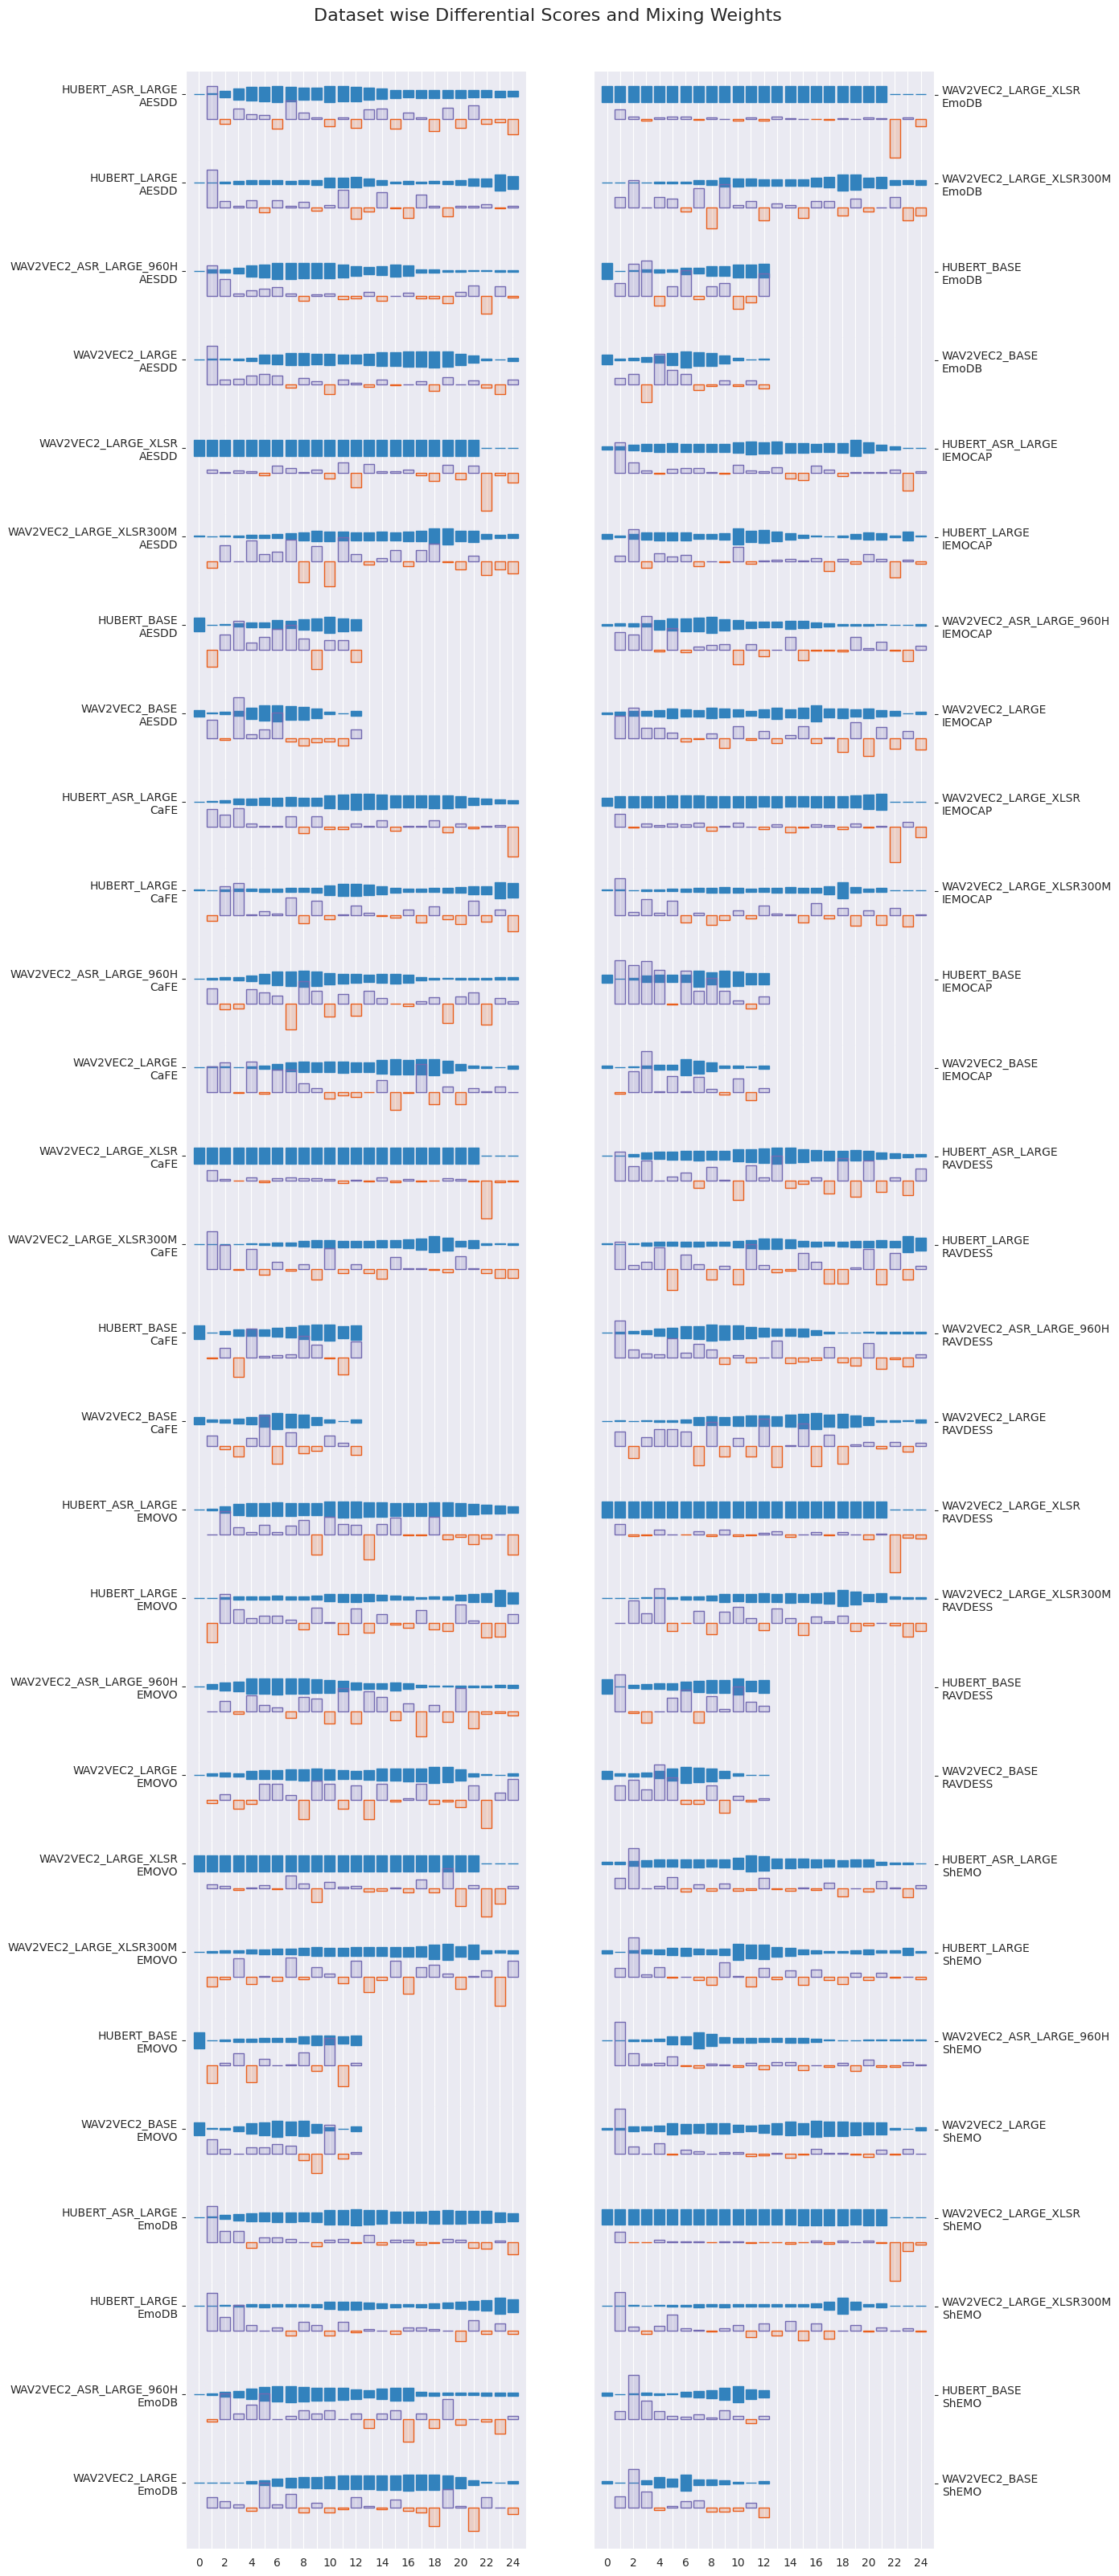

In [220]:
plt.clf();
plt.close('all');
sns.set_style('darkgrid')

cm_probing_linear_ds_mw = cm_probing_linear_ds_mw.sort_values(['dataset','layers','model'],ascending=[True,False,True]).reset_index(drop=True)

fig, axs = plt.subplots(cm_probing_linear_ds_mw.shape[0]//2, 2, sharex=True, figsize=(12,40))
fig.subplots_adjust(hspace=0)
axs = np.array(axs)
axs = list(axs[:,0]) + list(axs[:,1])

palette = ['#736ab133','#e95f1d33']
edge_palette = ['#736ab1','#e95f1d']

max_ds, min_ds = 0, 0
secondary_axs = []
for ax, (index, row) in zip(axs,cm_probing_linear_ds_mw.iterrows()):
    
    colors = [palette[0] if ds >= 0 else palette[1] for ds in row.differential_score]
    edge_colors = [edge_palette[0] if ds >= 0 else edge_palette[1] for ds in row.differential_score]

    # Plot mixing weights
    wts = normalize2(row.mixing_weight,0,0.35)
    ax.bar([*range(len(wts))], [2*w for w in wts], bottom=[-w for w in wts], color='#3282bd', edgecolor='#3282bd', linewidth=1)

    ax2 = ax.twinx()
    secondary_axs.append(ax2)

    # Plot differential scores
    scores = normalize(row.differential_score)
    max_ds = max(max_ds,max(scores))
    min_ds = min(min_ds,min(scores))
    ax2.bar([*range(1,len(scores)+1)], scores, color=colors, edgecolor=edge_colors)

    ax.grid(axis='x',visible=True)
    ax.grid(axis='y',visible=False)
    ax2.grid(axis='x',visible=True)
    ax2.grid(axis='y',visible=False)

    if index+1 > cm_probing_linear_ds_mw.shape[0]//2:
        ax2.set_yticks([0.45],[f'{row.model}\n{row.dataset}'])
        ax.set_yticks([],[])
    else:
        ax.set_yticks([0],[f'{row.model}\n{row.dataset}'])
        ax2.set_yticks([],[])
    ax2.spines[['bottom', 'top']].set_visible(False)
    ax.spines[['bottom', 'top']].set_visible(False)

for ax, ax2 in zip(axs,secondary_axs):
    ax.set_ylim((min_ds-0.05, max_ds+0.05))
    ax2.set_ylim((min_ds-0.05, max_ds+0.05))
    shift.yaxis(ax,0,0.75,True)

ax.set_xlim((-1,max(cm_probing_linear_ds_mw.layers)))
ax.set_xticks([*range(max(cm_probing_linear_ds_mw.layers))],[num if num%2==0 else "" for num in range(max(cm_probing_linear_ds_mw.layers))])
plt.suptitle('Dataset wise Differential Scores and Mixing Weights',y=0.9, fontsize=16)
plt.savefig(os.path.join(output_dir,'dataset_wise_cm_probing_linear_scores_weights.png'),bbox_inches="tight");

**3.1.1.2 Accuracy**

In [ ]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,20))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
datasets = sorted(cm_probing_linear_summary.dataset.unique())
for idx in range(len(datasets)):
    ax = axes[idx]
    dataset= datasets[idx]
    mean_accs, layers, models = [], [], []
    df = cm_probing_linear_summary[cm_probing_linear_summary.dataset==dataset]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        models.extend(([df.iloc[row].model]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(model=models,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='model',dashes=False,palette=sns.color_palette("husl",len(df.model.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(dataset)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,25,2)],labels=[*range(2,25,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-2].set_xlabel("Layer")
axes[-3].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
axes[-1].axis('off')
plt.suptitle('Dataset wise CM Probing Linear Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'dataset_wise_cm_probing_linear_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'dataset_wise_cm_probing_accuracy_plot.svg'),bbox_inches="tight");

# plt.clf();
# plt.close('all');

##### 3.1.2 Cumulative Probing Dense

**3.1.2.1 Differential Scores and Mixing Scores**

In [ ]:
plt.clf();
plt.close('all');
sns.set_style('darkgrid')

cm_probing_dense_ds_mw = cm_probing_dense_ds_mw.sort_values(['dataset','layers','model'],ascending=[True,False,True]).reset_index(drop=True)

fig, axs = plt.subplots(cm_probing_dense_ds_mw.shape[0]//2, 2, sharex=True, figsize=(12,40))
fig.subplots_adjust(hspace=0)
axs = np.array(axs)
axs = list(axs[:,0]) + list(axs[:,1])

palette = ['#736ab133','#e95f1d33']
edge_palette = ['#736ab1','#e95f1d']

max_ds, min_ds = 0, 0
secondary_axs = []
for ax, (index, row) in zip(axs,cm_probing_dense_ds_mw.iterrows()):
    
    colors = [palette[0] if ds >= 0 else palette[1] for ds in row.differential_score]
    edge_colors = [edge_palette[0] if ds >= 0 else edge_palette[1] for ds in row.differential_score]

    # Plot mixing weights
    wts = normalize2(row.mixing_weight,0,0.35)
    ax.bar([*range(len(wts))], [2*w for w in wts], bottom=[-w for w in wts], color='#3282bd', edgecolor='#3282bd', linewidth=1)

    ax2 = ax.twinx()
    secondary_axs.append(ax2)

    # Plot differential scores
    scores = normalize(row.differential_score)
    max_ds = max(max_ds,max(scores))
    min_ds = min(min_ds,min(scores))
    ax2.bar([*range(1,len(scores)+1)], scores, color=colors, edgecolor=edge_colors)

    ax.grid(axis='x',visible=True)
    ax.grid(axis='y',visible=False)
    ax2.grid(axis='x',visible=True)
    ax2.grid(axis='y',visible=False)

    if index+1 > cm_probing_dense_ds_mw.shape[0]//2:
        ax2.set_yticks([0.45],[f'{row.model}\n{row.dataset}'])
        ax.set_yticks([],[])
    else:
        ax.set_yticks([0],[f'{row.model}\n{row.dataset}'])
        ax2.set_yticks([],[])
    ax2.spines[['bottom', 'top']].set_visible(False)
    ax.spines[['bottom', 'top']].set_visible(False)

for ax, ax2 in zip(axs,secondary_axs):
    ax.set_ylim((min_ds-0.05, max_ds+0.05))
    ax2.set_ylim((min_ds-0.05, max_ds+0.05))
    shift.yaxis(ax,0,0.75,True)

ax.set_xlim((-1,max(cm_probing_dense_ds_mw.layers)))
ax.set_xticks([*range(max(cm_probing_dense_ds_mw.layers))],[num if num%2==0 else "" for num in range(max(cm_probing_dense_ds_mw.layers))])
plt.suptitle('Dataset wise Differential Scores and Mixing Weights',y=0.9, fontsize=16)
plt.savefig(os.path.join(output_dir,'dataset_wise_cm_probing_dense_scores_weights.png'),bbox_inches="tight");

**3.1.2.2 Accuracy**

In [7]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,20))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
datasets = sorted(cm_probing_dense_summary.dataset.unique())
for idx in range(len(datasets)):
    ax = axes[idx]
    dataset= datasets[idx]
    mean_accs, layers, models = [], [], []
    df = cm_probing_dense_summary[cm_probing_dense_summary.dataset==dataset]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        models.extend(([df.iloc[row].model]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(model=models,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='model',dashes=False,palette=sns.color_palette("husl",len(df.model.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(dataset)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,25,2)],labels=[*range(2,25,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-2].set_xlabel("Layer")
axes[-3].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
axes[-1].axis('off')
plt.suptitle('Dataset wise CM Probing Dense Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'dataset_wise_cm_probing_dense_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'dataset_wise_cm_probing_accuracy_plot.svg'),bbox_inches="tight");

# plt.clf();
# plt.close('all');

##### 3.1.3 Probing Linear

In [ ]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,20))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
datasets = sorted(probing_summary.dataset.unique())
for idx in range(len(datasets)):
    ax = axes[idx]
    dataset= datasets[idx]
    mean_accs, layers, models = [], [], []
    df = probing_summary[probing_summary.dataset==dataset]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        models.extend(([df.iloc[row].model]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(model=models,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='model',dashes=False,palette=sns.color_palette("husl",len(df.model.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(dataset)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,25,2)],labels=[*range(2,25,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-2].set_xlabel("Layer")
axes[-3].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
axes[-1].axis('off')
plt.suptitle('Dataset wise Probing Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.svg'),bbox_inches="tight");

# plt.clf();
# plt.close('all');

##### 3.1.4 Probing Dense

In [ ]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,20))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
datasets = sorted(probing_dense_summary.dataset.unique())
for idx in range(len(datasets)):
    ax = axes[idx]
    dataset= datasets[idx]
    mean_accs, layers, models = [], [], []
    df = probing_dense_summary[probing_dense_summary.dataset==dataset]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        models.extend(([df.iloc[row].model]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(model=models,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='model',dashes=False,palette=sns.color_palette("husl",len(df.model.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(dataset)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,25,2)],labels=[*range(2,25,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-2].set_xlabel("Layer")
axes[-3].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
axes[-1].axis('off')
plt.suptitle('Dataset wise Probing Dense Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'dataset_wise_probing_dense_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.svg'),bbox_inches="tight");

# plt.clf();
# plt.close('all');

#### 3.2 Model wise

##### 3.2.1 Cumulative Probing Linear

**3.2.1.1 Differential Scores and Mixing Scores**

In [ ]:
plt.clf();
plt.close('all');
sns.set_style('darkgrid')

cm_probing_linear_ds_mw = cm_probing_linear_ds_mw.sort_values(['model','dataset','layers'],ascending=[True,False,True]).reset_index(drop=True)

fig, axs = plt.subplots(cm_probing_linear_ds_mw.shape[0]//2, 2, sharex=True, figsize=(12,40))
fig.subplots_adjust(hspace=0)
axs = np.array(axs)
axs = list(axs[:,0]) + list(axs[:,1])

palette = ['#736ab133','#e95f1d33']
edge_palette = ['#736ab1','#e95f1d']

max_ds, min_ds = 0, 0
secondary_axs = []
for ax, (index, row) in zip(axs,cm_probing_linear_ds_mw.iterrows()):
    
    colors = [palette[0] if ds >= 0 else palette[1] for ds in row.differential_score]
    edge_colors = [edge_palette[0] if ds >= 0 else edge_palette[1] for ds in row.differential_score]

    # Plot mixing weights
    wts = normalize2(row.mixing_weight,0,0.35)
    ax.bar([*range(len(wts))], [2*w for w in wts], bottom=[-w for w in wts], color='#3282bd', edgecolor='#3282bd', linewidth=1)

    ax2 = ax.twinx()
    secondary_axs.append(ax2)

    # Plot differential scores
    scores = normalize(row.differential_score)
    max_ds = max(max_ds,max(scores))
    min_ds = min(min_ds,min(scores))
    ax2.bar([*range(1,len(scores)+1)], scores, color=colors, edgecolor=edge_colors)

    ax.grid(axis='x',visible=True)
    ax.grid(axis='y',visible=False)
    ax2.grid(axis='x',visible=True)
    ax2.grid(axis='y',visible=False)

    if index+1 > cm_probing_linear_ds_mw.shape[0]//2:
        ax2.set_yticks([0.45],[f'{row.model}\n{row.dataset}'])
        ax.set_yticks([],[])
    else:
        ax.set_yticks([0],[f'{row.model}\n{row.dataset}'])
        ax2.set_yticks([],[])
    ax2.spines[['bottom', 'top']].set_visible(False)
    ax.spines[['bottom', 'top']].set_visible(False)

for ax, ax2 in zip(axs,secondary_axs):
    ax.set_ylim((min_ds-0.05, max_ds+0.05))
    ax2.set_ylim((min_ds-0.05, max_ds+0.05))
    shift.yaxis(ax,0,0.75,True)

ax.set_xlim((-1,max(cm_probing_linear_ds_mw.layers)))
ax.set_xticks([*range(max(cm_probing_linear_ds_mw.layers))],[num if num%2==0 else "" for num in range(max(cm_probing_linear_ds_mw.layers))])
plt.suptitle('Model wise Differential Scores and Mixing Weights',y=0.9, fontsize=16)
plt.savefig(os.path.join(output_dir,'model_wise_cm_probing_linear_scores_weights.png'),bbox_inches="tight");

**3.2.1.2 Accuracy**

In [ ]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,19))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
models = sorted(cm_probing_linear_summary.model.unique())
for idx in range(len(models)):
    ax = axes[idx]
    model= models[idx]
    mean_accs, layers, datasets = [], [], []
    df = cm_probing_linear_summary[cm_probing_linear_summary.model==model]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        datasets.extend(([df.iloc[row].dataset]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(dataset=datasets,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='dataset',dashes=False,palette=sns.color_palette("husl",len(df.dataset.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(model)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,len(df.layer.unique())+1,2)],labels=[*range(2,len(df.layer.unique())+1,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-1].set_xlabel("Layer")
axes[-2].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
plt.suptitle('Model wise CM Probing Linear Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'model_wise_cm_probing_linear_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'model_wise_cm_probing_accuracy_plot.svg'),bbox_inches="tight");


# plt.clf();
# plt.close('all');

##### 3.2.2 Cumulative Probing Dense

**3.2.2.1 Differential Scores and Mixing Scores**

In [ ]:
plt.clf();
plt.close('all');
sns.set_style('darkgrid')

cm_probing_dense_ds_mw = cm_probing_dense_ds_mw.sort_values(['model','dataset','layers'],ascending=[True,False,True]).reset_index(drop=True)

fig, axs = plt.subplots(cm_probing_dense_ds_mw.shape[0]//2, 2, sharex=True, figsize=(12,40))
fig.subplots_adjust(hspace=0)
axs = np.array(axs)
axs = list(axs[:,0]) + list(axs[:,1])

palette = ['#736ab133','#e95f1d33']
edge_palette = ['#736ab1','#e95f1d']

max_ds, min_ds = 0, 0
secondary_axs = []
for ax, (index, row) in zip(axs,cm_probing_dense_ds_mw.iterrows()):
    
    colors = [palette[0] if ds >= 0 else palette[1] for ds in row.differential_score]
    edge_colors = [edge_palette[0] if ds >= 0 else edge_palette[1] for ds in row.differential_score]

    # Plot mixing weights
    wts = normalize2(row.mixing_weight,0,0.35)
    ax.bar([*range(len(wts))], [2*w for w in wts], bottom=[-w for w in wts], color='#3282bd', edgecolor='#3282bd', linewidth=1)

    ax2 = ax.twinx()
    secondary_axs.append(ax2)

    # Plot differential scores
    scores = normalize(row.differential_score)
    max_ds = max(max_ds,max(scores))
    min_ds = min(min_ds,min(scores))
    ax2.bar([*range(1,len(scores)+1)], scores, color=colors, edgecolor=edge_colors)

    ax.grid(axis='x',visible=True)
    ax.grid(axis='y',visible=False)
    ax2.grid(axis='x',visible=True)
    ax2.grid(axis='y',visible=False)

    if index+1 > cm_probing_dense_ds_mw.shape[0]//2:
        ax2.set_yticks([0.45],[f'{row.model}\n{row.dataset}'])
        ax.set_yticks([],[])
    else:
        ax.set_yticks([0],[f'{row.model}\n{row.dataset}'])
        ax2.set_yticks([],[])
    ax2.spines[['bottom', 'top']].set_visible(False)
    ax.spines[['bottom', 'top']].set_visible(False)

for ax, ax2 in zip(axs,secondary_axs):
    ax.set_ylim((min_ds-0.05, max_ds+0.05))
    ax2.set_ylim((min_ds-0.05, max_ds+0.05))
    shift.yaxis(ax,0,0.75,True)

ax.set_xlim((-1,max(cm_probing_dense_ds_mw.layers)))
ax.set_xticks([*range(max(cm_probing_dense_ds_mw.layers))],[num if num%2==0 else "" for num in range(max(cm_probing_dense_ds_mw.layers))])
plt.suptitle('Model wise Differential Scores and Mixing Weights',y=0.9, fontsize=16)
plt.savefig(os.path.join(output_dir,'model_wise_cm_probing_dense_scores_weights.png'),bbox_inches="tight");

**3.2.2.2 Accuracy**

In [ ]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,19))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
models = sorted(cm_probing_dense_summary.model.unique())
for idx in range(len(models)):
    ax = axes[idx]
    model= models[idx]
    mean_accs, layers, datasets = [], [], []
    df = cm_probing_dense_summary[cm_probing_dense_summary.model==model]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        datasets.extend(([df.iloc[row].dataset]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(dataset=datasets,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='dataset',dashes=False,palette=sns.color_palette("husl",len(df.dataset.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(model)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,len(df.layer.unique())+1,2)],labels=[*range(2,len(df.layer.unique())+1,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-1].set_xlabel("Layer")
axes[-2].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
plt.suptitle('Model wise CM Probing Dense Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'model_wise_cm_probing_dense_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'model_wise_cm_probing_accuracy_plot.svg'),bbox_inches="tight");


# plt.clf();
# plt.close('all');

##### 3.2.3 Probing Linear

In [ ]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,19))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
models = sorted(probing_summary.model.unique())
for idx in range(len(models)):
    ax = axes[idx]
    model= models[idx]
    mean_accs, layers, datasets = [], [], []
    df = probing_summary[probing_summary.model==model]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        datasets.extend(([df.iloc[row].dataset]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(dataset=datasets,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='dataset',dashes=False,palette=sns.color_palette("husl",len(df.dataset.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(model)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,len(df.layer.unique())+1,2)],labels=[*range(2,len(df.layer.unique())+1,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-1].set_xlabel("Layer")
axes[-2].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
plt.suptitle('Model wise Probing Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.svg'),bbox_inches="tight");


# plt.clf();
# plt.close('all');

##### 3.2.4 Probing Dense

In [ ]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,19))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
models = sorted(probing_dense_summary.model.unique())
for idx in range(len(models)):
    ax = axes[idx]
    model= models[idx]
    mean_accs, layers, datasets = [], [], []
    df = probing_dense_summary[probing_dense_summary.model==model]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        datasets.extend(([df.iloc[row].dataset]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(dataset=datasets,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='dataset',dashes=False,palette=sns.color_palette("husl",len(df.dataset.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(model)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,len(df.layer.unique())+1,2)],labels=[*range(2,len(df.layer.unique())+1,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-1].set_xlabel("Layer")
axes[-2].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
plt.suptitle('Model wise Probing Dense Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'model_wise_probing_dense_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.svg'),bbox_inches="tight");


# plt.clf();
# plt.close('all');

In [ ]:
plt.clf()
plt.close('all')